In [1]:
import warnings
warnings.filterwarnings("ignore") 

In [2]:
import pandas as pd 
df=pd.read_csv('C:\\workplace\\power-consumption\\dataset\\processed.csv',index_col=0)
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-01-01 00:00,6.196833,75.066667,0.081833,0.063500,0.098833,22158.923532
2017-01-01 01:00,5.548833,77.583333,0.082000,0.056833,0.112500,19259.508737
2017-01-01 02:00,5.054333,78.933333,0.082333,0.063000,0.129167,17363.293880
2017-01-01 03:00,5.004333,77.083333,0.082833,0.059833,0.141000,16304.815849
2017-01-01 04:00,5.097667,74.050000,0.082333,0.058000,0.122833,15904.879449


In [3]:
df.shape

(8736, 6)

In [4]:
train_df=df.iloc[:5000-7]
y_test=df.iloc[5000-7:,-1]
test_df=df.iloc[5000-7:]

In [5]:
train_df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-01-01 00:00,6.196833,75.066667,0.081833,0.063500,0.098833,22158.923532
2017-01-01 01:00,5.548833,77.583333,0.082000,0.056833,0.112500,19259.508737
2017-01-01 02:00,5.054333,78.933333,0.082333,0.063000,0.129167,17363.293880
2017-01-01 03:00,5.004333,77.083333,0.082833,0.059833,0.141000,16304.815849
2017-01-01 04:00,5.097667,74.050000,0.082333,0.058000,0.122833,15904.879449
...,...,...,...,...,...,...
2017-07-27 20:00,27.843333,61.208333,4.906667,13.574167,11.094667,44231.353009
2017-07-27 21:00,27.210000,62.086667,4.907500,0.083333,0.085333,42667.595168
2017-07-27 22:00,26.566667,71.410000,4.906333,0.089333,0.101167,40407.914353


In [6]:
triggered=pd.to_datetime(test_df.reset_index()['Datetime']).dt.strftime('%Y-%m-%d 00:00').unique()
len(triggered)

156

In [7]:
from sklearn.preprocessing import PowerTransformer 
scaler= PowerTransformer().fit(train_df)
train_df2=pd.DataFrame(scaler.transform(train_df),columns=train_df.columns)

In [8]:
train_df2

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
0,-2.519122,0.365458,-0.675575,-1.047975,-1.066473,-0.196897
1,-2.730180,0.559973,-0.675066,-1.050480,-1.060742,-0.784657
2,-2.900476,0.667014,-0.674049,-1.048163,-1.053851,-1.216934
3,-2.918187,0.520806,-0.672525,-1.049351,-1.049022,-1.478381
4,-2.885203,0.288735,-0.674049,-1.050040,-1.056457,-1.581429
...,...,...,...,...,...,...
4988,1.565400,-0.588661,1.466105,-0.053800,-0.006063,2.749115
4989,1.482930,-0.534053,1.466148,-1.040620,-1.072207,2.593667
4990,1.397928,0.094489,1.466088,-1.038422,-1.065489,2.359095
4991,1.269812,0.707137,1.465983,-1.036358,-1.065419,1.963068


In [9]:
import numpy as np
def make_supervise(train_df2,target_name,num_lags,num_steps):
    X_train=pd.DataFrame()
    for i in range(num_lags):
        for feat in train_df2.columns:
            X_train[feat+' '+'lag_{}'.format(num_lags-1-i)]=train_df2[feat].shift(num_lags-1-i)

    y_train=pd.DataFrame() 
    for i in range(1,num_steps+1):
        y_train[target_name+' '+'steps_{}'.format(i)]=train_df2[target_name].shift(-i)

    train_df3=pd.concat([X_train,y_train],axis=1).dropna()
    return train_df3

In [10]:
train_df3=make_supervise(train_df2,'PowerConsumption',24,24)

In [11]:
X_train=np.array(train_df3[train_df3.columns[train_df3.columns.str.contains('lag')]]).reshape(train_df3.shape[0],24,train_df.shape[1])
y_train=np.array(train_df3[train_df3.columns[train_df3.columns.str.contains('steps')]])

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,LSTM
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
from sklearn.model_selection import  train_test_split 
from sklearn.metrics import mean_absolute_percentage_error
X_fit,X_val,y_fit,y_val=train_test_split(X_train,y_train,shuffle=False,test_size=0.3)

In [14]:
stop_rul=EarlyStopping(patience=10)

In [15]:
def val_fun(X_fit,y_fit,X_val,y_val,num_layers,num_nerons,alpha,iter,b_s):

    # Input layer
    model=Sequential()
    #model.add(Input(X_fit.shape[0],X_fit.shape[1],X_fit.shape[2]))
    # Hidden Layers
    for i in range(num_layers):
        if i==0:
            if num_layers>1:
                model.add(LSTM(units=num_nerons,return_sequences=True,input_shape=(X_fit.shape[1],X_fit.shape[2])))
            else:
                model.add(LSTM(units=num_nerons,return_sequences=False,input_shape=(X_fit.shape[1],X_fit.shape[2]))) 
        elif i<num_layers-1:
            model.add(LSTM(units=num_nerons,return_sequences=True))
        else :
            model.add(LSTM(units=num_nerons))
    # output layer
    model.add(Dense(units=24))
    # Training
    model.compile(optimizer=Adam(learning_rate=alpha),loss=MeanAbsoluteError())
    model.fit(X_fit,y_fit,validation_data=(X_val,y_val),epochs=iter,batch_size=b_s,callbacks=[stop_rul])
    # Evaluation of the model
    #pred=model.predict(X_val)
    #y_val2=scaler.inverse_transform(np.array(y_val).reshape(-1,1))
    #pred2=scaler.inverse_transform(pred.reshape(-1,1))
    #error=mean_absolute_percentage_error(y_val2,pred2)
    return pd.DataFrame(model.history.history).iloc[:,1].min()

In [16]:
cv=val_fun(X_fit,y_fit,X_val,y_val,2,128,0.0001,1000,128)

Epoch 1/1000
28/28 [==============================] - 9s 127ms/step - loss: 0.7409 - val_loss: 0.9041
Epoch 2/1000
28/28 [==============================] - 3s 97ms/step - loss: 0.6695 - val_loss: 0.8479
Epoch 3/1000
28/28 [==============================] - 3s 103ms/step - loss: 0.5216 - val_loss: 0.7822
Epoch 4/1000
28/28 [==============================] - 3s 95ms/step - loss: 0.3841 - val_loss: 0.7464
Epoch 5/1000
28/28 [==============================] - 3s 100ms/step - loss: 0.3026 - val_loss: 0.7119
Epoch 6/1000
28/28 [==============================] - 3s 94ms/step - loss: 0.2491 - val_loss: 0.6864
Epoch 7/1000
28/28 [==============================] - 3s 99ms/step - loss: 0.2201 - val_loss: 0.6835
Epoch 8/1000
28/28 [==============================] - 3s 94ms/step - loss: 0.2045 - val_loss: 0.6810
Epoch 9/1000
28/28 [==============================] - 3s 97ms/step - loss: 0.1968 - val_loss: 0.6781
Epoch 10/1000
28/28 [==============================] - 3s 93ms/step - loss: 0.1916 - val

In [18]:
num_layers=2;num_nerons=128;alpha=0.0001;iter=228;b_s=128
model=Sequential()
#model.add(Input(X_fit.shape[0],X_fit.shape[1],X_fit.shape[2]))
# Hidden Layers
for i in range(num_layers):
    if i==0:
        if num_layers>1:
                model.add(LSTM(units=num_nerons,return_sequences=True,input_shape=(X_fit.shape[1],X_fit.shape[2])))
        else:
                model.add(LSTM(units=num_nerons,return_sequences=False,input_shape=(X_fit.shape[1],X_fit.shape[2]))) 
    elif i<num_layers-1:
            model.add(LSTM(units=num_nerons,return_sequences=True))
    else :
            model.add(LSTM(units=num_nerons))
    # output layer
model.add(Dense(units=24))
    # Training
model.compile(optimizer=Adam(learning_rate=alpha),loss=MeanAbsoluteError())
model.fit(X_train,y_train,epochs=iter,batch_size=b_s)

Epoch 1/228
39/39 [==============================] - 8s 68ms/step - loss: 0.7891
Epoch 2/228
39/39 [==============================] - 3s 73ms/step - loss: 0.6881
Epoch 3/228
39/39 [==============================] - 3s 74ms/step - loss: 0.5051
Epoch 4/228
39/39 [==============================] - 3s 77ms/step - loss: 0.3607
Epoch 5/228
39/39 [==============================] - 3s 77ms/step - loss: 0.2841
Epoch 6/228
39/39 [==============================] - 3s 75ms/step - loss: 0.2492
Epoch 7/228
39/39 [==============================] - 3s 82ms/step - loss: 0.2335
Epoch 8/228
39/39 [==============================] - 4s 93ms/step - loss: 0.2243
Epoch 9/228
39/39 [==============================] - 3s 83ms/step - loss: 0.2174
Epoch 10/228
39/39 [==============================] - 5s 120ms/step - loss: 0.2126
Epoch 11/228
39/39 [==============================] - 5s 138ms/step - loss: 0.2082
Epoch 12/228
39/39 [==============================] - 3s 77ms/step - loss: 0.2044
Epoch 13/228
39/39 [===

# Testing

In [33]:
from sklearn.preprocessing import PowerTransformer 
scaler= PowerTransformer().fit(df)
test_df2=pd.DataFrame(scaler.transform(df),columns=train_df.columns)

In [34]:
test_df2=make_supervise(test_df2,'PowerConsumption',24,24)

In [96]:
test_df3=test_df2.tail(len(triggered)*24)
test_df3.index=df.index[df.index>='2017-07-28 00:00']
test_df3=test_df3.loc[test_df3.index[pd.to_datetime(pd.Series(test_df3.index)).dt.hour==0]]
test_df3

,Temperature lag_23,Humidity lag_23,WindSpeed lag_23,GeneralDiffuseFlows lag_23,DiffuseFlows lag_23,PowerConsumption lag_23,Temperature lag_22,Humidity lag_22,WindSpeed lag_22,GeneralDiffuseFlows lag_22,...,PowerConsumption steps_15,PowerConsumption steps_16,PowerConsumption steps_17,PowerConsumption steps_18,PowerConsumption steps_19,PowerConsumption steps_20,PowerConsumption steps_21,PowerConsumption steps_22,PowerConsumption steps_23,PowerConsumption steps_24
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-07-28 00:00,0.664971,0.246496,1.250608,-1.008549,-1.011684,0.928508,0.717842,-0.419010,1.250591,-1.009425,...,1.667654,1.583068,1.554004,1.619006,2.229847,2.675249,2.531768,2.313987,1.942807,1.445436
2017-07-29 00:00,1.172697,-1.376378,1.250771,-1.003800,-1.018073,0.918758,1.143781,-1.409162,1.250788,-1.000488,...,1.634426,1.569151,1.333338,1.396515,1.979109,2.430012,2.299302,2.106699,1.759210,1.298617
2017-07-30 00:00,1.459424,-0.848422,1.250821,-1.002406,-1.031346,0.960039,1.430828,-0.920219,1.250837,-1.000884,...,1.331304,1.303283,1.315675,1.388478,2.038327,2.491161,2.333966,2.102789,1.775222,1.325639
2017-07-31 00:00,1.159940,-1.313010,1.250853,-1.004599,-1.032223,0.818347,1.263744,-1.580910,1.250837,-1.001611,...,1.123489,1.096283,1.122726,1.237611,1.927737,2.417923,2.276663,2.064297,1.745699,1.313923
2017-08-01 00:00,0.851748,-0.260386,1.250476,-1.004332,-1.031426,0.909622,0.835751,-0.365663,1.250575,-1.004732,...,1.580569,1.468506,1.454962,1.481644,2.100997,2.480166,2.334335,2.088437,1.709527,1.222185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26 00:00,-1.651671,1.526423,-0.816479,-1.025654,-1.003571,-1.172358,-1.856152,1.522025,-0.817499,-1.021397,...,-0.011421,-0.009000,0.835833,1.168022,1.112052,1.080040,0.898636,0.473911,-0.116061,-0.712704
2017-12-27 00:00,-1.806659,1.365229,-0.815120,-1.020981,-1.007421,-1.215842,-1.911684,1.421506,-0.814102,-1.019596,...,0.111565,0.039792,0.831383,1.170724,1.135066,1.088777,0.870606,0.481566,-0.104804,-0.706573
2017-12-28 00:00,-1.869551,0.821213,-0.814441,-1.019182,-1.012143,-1.174011,-2.042964,1.148209,-0.814102,-1.019942,...,0.059808,0.076596,0.866333,1.176922,1.124776,1.100428,0.896628,0.524390,-0.106873,-0.698388


In [98]:
X_test=np.array(test_df3[test_df3.columns[test_df3.columns.str.contains('lag')]])#.reshape(test_df.shape[0],24,test_df.shape[1])
X_test=X_test.reshape(X_test.shape[0],24,6)
y_test=np.array(test_df3[test_df3.columns[test_df3.columns.str.contains('steps')]])

In [116]:
pred=model.predict(X_test)

5/5 [==============================] - 0s 15ms/step


In [131]:
pred_series=pd.Series(pred.reshape(-1)[:-1],index=test_df.index)
pred_df=test_df.copy()
pred_df['PowerConsumption']=pred_series
pred_df=scaler.inverse_transform(pred_df)
pred_df=pd.DataFrame(pred_df,columns=test_df.columns,index=test_df.index)
pred_df

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption
Datetime,,,,,,
2017-07-28 01:00,297.950758,355.986247,NaN,16.302727,10.642881,28163.400107
2017-07-28 02:00,295.495404,352.057406,NaN,16.486445,10.540752,26305.943504
2017-07-28 03:00,283.418010,361.327238,NaN,16.398322,10.692069,25767.172443
2017-07-28 04:00,277.102849,364.707054,NaN,16.510561,10.800170,23702.347587
2017-07-28 05:00,265.342409,370.014411,NaN,16.382350,10.927652,21001.010918
...,...,...,...,...,...,...
2017-12-30 19:00,91.661496,373.617124,0.758469,14.300476,10.745985,31192.637464
2017-12-30 20:00,87.863635,378.289051,0.765113,14.328369,10.827363,30376.685948
2017-12-30 21:00,78.572834,394.634481,0.766487,15.213106,10.647343,29445.338930


In [132]:
mean_absolute_percentage_error(test_df['PowerConsumption'],pred_df['PowerConsumption'])

0.05007638557019714

<Axes: xlabel='Datetime'>

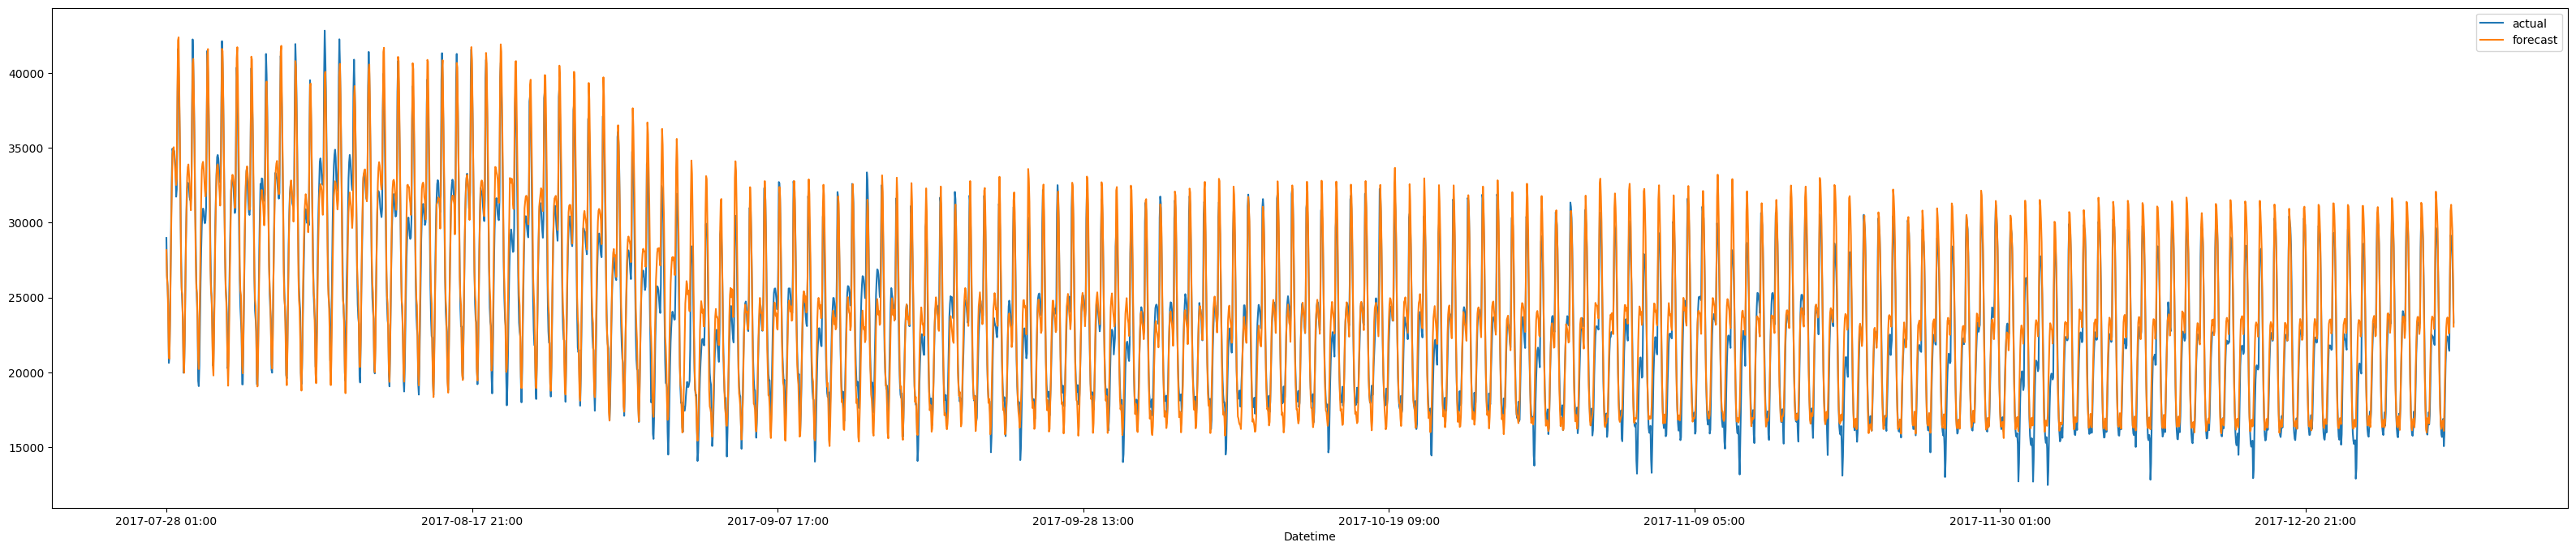

In [135]:
test_score_df=pd.concat([test_df['PowerConsumption'],pred_df['PowerConsumption']],axis=1)
test_score_df.columns=['actual','forecast']
test_score_df.plot(figsize=(40,8))

In [136]:
test_score_df

,actual,forecast
Datetime,,
2017-07-28 01:00,28977.450352,28163.400107
2017-07-28 02:00,26477.507331,26305.943504
2017-07-28 03:00,25739.260298,25767.172443
2017-07-28 04:00,24527.400354,23702.347587
2017-07-28 05:00,20630.238959,21001.010918
...,...,...
2017-12-30 19:00,28979.428115,31192.637464
2017-12-30 20:00,28675.974373,30376.685948
2017-12-30 21:00,27574.986552,29445.338930


In [137]:
import plotly.graph_objects as go
figure=go.Figure()
figure.add_trace(go.Scatter(y=test_score_df['actual'],name='actual_electricity_consumption'))
figure.add_trace(go.Scatter(y=test_score_df['forecast'],name='lstm_forecast'))